In this exercise we will classify stimulus classes using the Haxby et al. data. You should first obtain the data using the command:

wget http://data.pymvpa.org/datasets/haxby2001/subj1-2010.01.14.tar.gz

and set the datadir variable accordingly

In [1]:
import nipype.algorithms.modelgen as model   # model generation
import nipype.interfaces.fsl as fsl          # fsl
from nipype.interfaces.base import Bunch
import os,json,glob
import numpy
import nibabel
import nilearn.plotting
import sklearn.multiclass
from sklearn.svm import LinearSVC
import sklearn.metrics


%matplotlib inline
import matplotlib.pyplot as plt


datadir='/Users/poldrack/data_unsynced/haxby/subj1'

print 'Using data from',datadir


tr=2.5

boldfile=os.path.join(datadir,'bold.nii.gz')
maskfile=os.path.join(datadir,'mask4_vt.nii.gz')
boldimg=nibabel.load(boldfile)
maskimg=nibabel.load(maskfile)




Using data from /Users/poldrack/data_unsynced/haxby/subj1


events

In [68]:
labelfile=os.path.join(datadir,'labels.txt')
lines=open(labelfile).readlines()
lines=lines[1:] # drop header

# find all block onsets
conditions=[]
condnums=[]
onsets=[]
durations=[]
runs=[]
cond=''
condctr=1

cond_dict={'scissors':1,
 'face':2,
 'cat':3,
 'shoe':4,
 'house':5,
 'scrambledpix':6,
 'bottle':7,
 'chair':8}
condlabels=['scissors','face','cat','shoe','house','scrambledpix','bottle','chair']

for i in range(len(lines)):
    l_s=lines[i].strip().split()
    if l_s[0]=='rest':
        continue
    if not l_s[0]==cond:
        cond=l_s[0]
        runs.append(int(l_s[1]))
        conditions.append('-'.join(l_s))
        condnums.append(cond_dict[l_s[0]])
        onsets.append([tr*(i+1)])
        durations.append([22.5])
    
condnums=numpy.array(condnums)
runs=numpy.array(runs)

Set up model


In [3]:
modeldir=os.path.join(datadir,'blockmodel')
# no way to specify the output directory, so we just chdir into the 
# desired output directory
if not os.path.exists(modeldir):
    os.mkdir(modeldir)
os.chdir(modeldir)


info = [Bunch(conditions=conditions,
              onsets=onsets,
              durations=durations)
       ]

s = model.SpecifyModel()
s.inputs.input_units = 'secs'
s.inputs.functional_runs = [os.path.join(datadir,'bold.nii.gz')]
s.inputs.time_repetition = tr
s.inputs.high_pass_filter_cutoff = 128.
s.inputs.subject_info = info
s.run()




In [4]:
contrasts=[]

for i in range(len(conditions)):
    contrasts.append([conditions[i],'T',[conditions[i]],[1]])

           
level1design = fsl.model.Level1Design()
level1design.inputs.interscan_interval = tr
level1design.inputs.bases = {'dgamma':{'derivs': False}}
level1design.inputs.session_info = s._sessinfo
level1design.inputs.model_serial_correlations=False
level1design.inputs.contrasts=contrasts
level1info=level1design.run() 

fsf_file=os.path.join(modeldir,'run0.fsf')
event_files=glob.glob(os.path.join(modeldir,'ev*txt'))


In [5]:
modelgen=fsl.model.FEATModel()
modelgen.inputs.fsf_file=fsf_file
modelgen.inputs.ev_files=event_files
modelgen.run()




KeyboardInterrupt: 

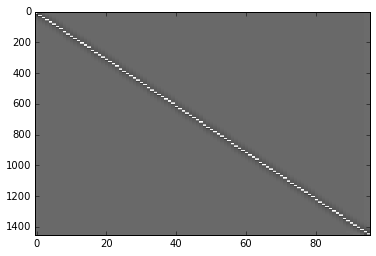

In [9]:
desmtx=numpy.loadtxt(fsf_file.replace(".fsf",".mat"),skiprows=5)
plt.imshow(desmtx,aspect='auto',interpolation='nearest',cmap='gray')


Estimate the model with a separate condition for each block.  We would usually use FSL, but it's very slow given the size of the dataset, so we just perform the GLM manually to get the betas for each condition/voxel.

In [18]:
# this is how one could do it using FSL - this is VERY slow, so let's compute the GLM on our own
if 0: #not os.path.exists(os.path.join(modeldir,'stats')):
    fgls = fsl.FILMGLS(smooth_autocorr=True,mask_size=5)
    fgls.inputs.in_file =os.path.join(datadir,'bold.nii.gz')
    fgls.inputs.design_file = os.path.join(modeldir,'run0.mat')
    fgls.inputs.threshold = 10
    fgls.inputs.results_dir = os.path.join(modeldir,'stats')
    fgls.inputs.tcon_file=os.path.join(modeldir,'run0.con')
    res = fgls.run() 

else:
    bolddata=boldimg.get_data()
    maskvox=maskimg.get_data()>0
    vtdata=numpy.zeros((bolddata.shape[3],numpy.sum(maskvox)))
    for tp in range(bolddata.shape[3]):
        vtdata[tp,:]=bolddata[:,:,:,tp][maskvox]
    
    betas=numpy.linalg.inv(desmtx.T.dot(desmtx)).dot(desmtx.T.dot(vtdata))
    


Now let's do a leave-one-run out classifier.

In [65]:
run_vals=list(numpy.unique(runs))

pred=numpy.zeros(len(conditions)) # predicted class

baseclf=LinearSVC()

clf=sklearn.multiclass.OneVsRestClassifier(baseclf)
shuffle_labels=False

for testrun in run_vals:
    testdata=betas[runs==testrun,:]
    traindata=betas[runs!=testrun,:]
    trainlabels=condnums[runs!=testrun]
    if shuffle_labels:
        numpy.random.shuffle(trainlabels)
    clf.fit(traindata,trainlabels)
    pred[run_array==testrun]=clf.predict(testdata)

In [73]:
confmtx=sklearn.metrics.confusion_matrix(condnums,pred)
print confmtx
acc=sklearn.metrics.accuracy_score(condnums,pred)
print 'Accuracy score:',acc

[[ 6  0  0  2  0  1  2  1]
 [ 1  9  2  0  0  0  0  0]
 [ 1  2  9  0  0  0  0  0]
 [ 2  0  0  8  0  0  1  1]
 [ 1  0  0  1 10  0  0  0]
 [ 0  0  0  0  0 12  0  0]
 [ 0  0  0  2  0  1  7  2]
 [ 2  0  0  2  0  0  0  8]]
Accuracy score: 0.71875
